In [1]:
import numpy as np
import pandas as pd
import os

cwd = os.getcwd()

# Convert the data into Python dataframe.
finance_dataset = pd.read_csv(f"{cwd}/labelled_news.csv")
# total number of rows, each attribute type and number of non null values
finance_dataset.info()

# How many categories exists and how much data belong to each category
finance_dataset['Label'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4176 entries, 0 to 4175
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  4176 non-null   int64  
 1   Date        4176 non-null   object 
 2   Summary     4176 non-null   object 
 3   Label       4176 non-null   float64
 4   Close       4176 non-null   float64
dtypes: float64(2), int64(1), object(2)
memory usage: 163.2+ KB


1.0    2208
0.0    1968
Name: Label, dtype: int64

In [2]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import *
from sklearn.metrics import accuracy_score

def clean_data(data):
    #removes the rows that contains NULL values and inplace modifies the original datset instead of creating anew one
    summarised_data = data
    summarised_data.dropna(inplace=True)
    #Change all the text to lower case. This is required as python interprets lowercase and uppercase differently
    summarised_data = [entry.lower() for entry in summarised_data]
    #Tokenization : In this each entry in the corpus will be broken into set of words
    summarised_data = [word_tokenize(entry) for entry in summarised_data]
    #Remove stopwords
    english_stop_words=set(stopwords.words("english"))
    summarised_data=list(map(lambda l: list(filter(lambda summarised_data: summarised_data not in english_stop_words, l)), summarised_data))
    # Lemmatisation. This is required to convert the word into root form
    wordnet_lemmatizer = WordNetLemmatizer()
    summarised_data=list(map(lambda l: list(filter(lambda summarised_data: summarised_data in wordnet_lemmatizer.lemmatize(summarised_data), l)), summarised_data))
    summarised_words_list = summarised_data
    # convert list to string
    summarised_data = [' '.join(map(str, l)) for l in summarised_data]
    return summarised_data, summarised_words_list

In [3]:
import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

summarised_data, summarised_words_list = clean_data(finance_dataset['Summary'])
finance_dataset['preprocessed_text'] = summarised_data
finance_dataset['preprocessed_words_list'] = summarised_words_list
finance_dataset.info()
finance_dataset['Label'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4176 entries, 0 to 4175
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               4176 non-null   int64  
 1   Date                     4176 non-null   object 
 2   Summary                  4176 non-null   object 
 3   Label                    4176 non-null   float64
 4   Close                    4176 non-null   float64
 5   preprocessed_text        4176 non-null   object 
 6   preprocessed_words_list  4176 non-null   object 
dtypes: float64(2), int64(1), object(4)
memory usage: 228.5+ KB


1.0    2208
0.0    1968
Name: Label, dtype: int64

<AxesSubplot:>

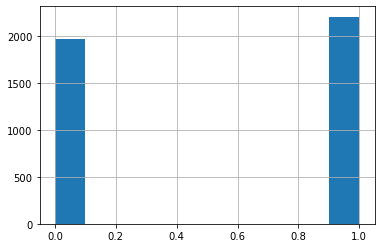

In [4]:
finance_dataset['Label'].hist()

In [5]:
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical

l_encode = LabelEncoder()
l_encode.fit(finance_dataset['Label'])
y = l_encode.transform(finance_dataset['Label'])
y = to_categorical(y)
y

2023-03-10 18:44:15.633257: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-10 18:44:15.746284: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-10 18:44:15.749762: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-10 18:44:15.749773: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [6]:
from scipy import spatial
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.tokenize import word_tokenize


In [7]:
x = finance_dataset['preprocessed_text']
x_train,x_test,y_train,y_test= train_test_split(x, y, test_size = 0.20, stratify=y, random_state = 58)
print('X train size = ' , x_train.shape)
print('Y train size = ' , y_train.shape)
print('X test size = ' , x_test.shape)
print('Y test size = ' , y_test.shape)

texts =x_train
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(texts)

vocab_length = len(word_tokenizer.word_index) + 1
print('vocab_length', vocab_length)


def embed(corpus, word_tokenizer): 
    return word_tokenizer.texts_to_sequences(corpus)

longest_train = max(texts, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))
train_padded_sentences = pad_sequences(
    embed(texts, word_tokenizer), 
    256, 
    padding='post'
)

print('train_padded_sentences shape' , train_padded_sentences.shape)


X train size =  (3340,)
Y train size =  (3340, 2)
X test size =  (836,)
Y test size =  (836, 2)
vocab_length 11918
train_padded_sentences shape (3340, 256)


In [8]:
embeddings_dictionary = dict()
embedding_dim = 50

# Load GloVe 50D embeddings

with open('/home/varada/Documents/00_SEMESTER4/stock_prediction/binary/glove.6B/glove.6B.50d.txt') as fp:
# with open('/home/varada/Documents/categorisation/set_1/glove.42B.300d.txt') as fp:
    for line in fp.readlines():
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary [word] = vector_dimensions

# Now we will load embedding vectors of those words that appear in the
# Glove dictionary. Others will be initialized to 0.

embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
        
embedding_matrix.shape

(11918, 50)

In [9]:
from tensorflow import keras
from tensorflow.keras.initializers import Constant
import numpy as np
import tensorflow as tf

tf.random.set_seed(8634)

text_input = keras.layers.Input(shape=(None,), name="preprocessed_text")

# Embed each word in the title into a embedding_dim-dimensional vector
text_features = keras.layers.Embedding(vocab_length,embedding_dim,embeddings_initializer=Constant(embedding_matrix),input_length=embedding_dim,trainable=False)(text_input)

# Reduce sequence of embedded words in the positive_text into a single length_long_sentence-dimensional vector
text_features = keras.layers.Bidirectional(keras.layers.LSTM(256, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(text_features)
layer_2 = keras.layers.Bidirectional(keras.layers.LSTM(128, dropout=0.1, recurrent_dropout=0.1))(text_features)


label_pred = keras.layers.Dense(2,  activation='softmax', name="Label")(layer_2)

# Instantiate an end-to-end model predicting both priority and department
model = keras.Model(
    inputs=[text_input,],
    outputs=[label_pred],
)
optimzer=keras.optimizers.Adam(learning_rate=3e-4)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()



2023-03-10 18:44:19.689823: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-10 18:44:19.689885: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-10 18:44:19.689915: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (QB-CLT-1107): /proc/driver/nvidia/version does not exist
2023-03-10 18:44:19.690312: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocessed_text (InputLay  [(None, None)]           0         
 er)                                                             
                                                                 
 embedding (Embedding)       (None, None, 50)          595900    
                                                                 
 bidirectional (Bidirectiona  (None, None, 512)        628736    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              656384    
 nal)                                                            
                                                                 
 Label (Dense)               (None, 2)                 514       
                                                             

In [10]:
x_train_emb,x_valid_emb,y_train_emb,y_valid_emb = train_test_split(train_padded_sentences,y_train,test_size=0.2, random_state=42)


history = model.fit(x=[x_train_emb], y=y_train_emb, 
          validation_data=([x_valid_emb], y_valid_emb), epochs=20, batch_size=32, verbose=1)
preds =model.predict(x=[x_valid_emb])
# # print(preds)
# print(x_train_emb.shape, x_pos_score_train.shape, x_neg_score_train.shape, y_pos_score_valid.shape)

Epoch 1/20
84/84 [==============================] - 134s 2s/step - loss: 0.6987 - accuracy: 0.5086 - val_loss: 0.6916 - val_accuracy: 0.5254
Epoch 2/20
84/84 [==============================] - 125s 1s/step - loss: 0.6910 - accuracy: 0.5400 - val_loss: 0.6930 - val_accuracy: 0.5374
Epoch 3/20
84/84 [==============================] - 124s 1s/step - loss: 0.6890 - accuracy: 0.5269 - val_loss: 0.6927 - val_accuracy: 0.5404
Epoch 4/20
84/84 [==============================] - 124s 1s/step - loss: 0.6864 - accuracy: 0.5460 - val_loss: 0.6953 - val_accuracy: 0.5030
Epoch 5/20
84/84 [==============================] - 124s 1s/step - loss: 0.6814 - accuracy: 0.5816 - val_loss: 0.7120 - val_accuracy: 0.5225
Epoch 6/20
84/84 [==============================] - 124s 1s/step - loss: 0.6783 - accuracy: 0.5696 - val_loss: 0.7026 - val_accuracy: 0.5225
Epoch 7/20
84/84 [==============================] - 124s 1s/step - loss: 0.6667 - accuracy: 0.5887 - val_loss: 0.7183 - val_accuracy: 0.5045
Epoch 8/20
84

In [11]:
scores = model.evaluate([x_valid_emb], y_valid_emb)


21/21 [==============================] - 5s 239ms/step - loss: 2.1248 - accuracy: 0.5000


In [12]:
def metrics(y_true, y_pred):
    print('Accuracy Score:', round(accuracy_score(y_true, y_pred),2))
    print('\nClassification Score:\n', classification_report(y_true, y_pred))
    print('\nConfusion Matrix:\n', confusion_matrix(y_true, y_pred))

metrics(y_valid_emb.argmax(1), preds.argmax(1))

Accuracy Score: 0.5

Classification Score:
               precision    recall  f1-score   support

           0       0.46      0.48      0.47       311
           1       0.53      0.52      0.53       357

    accuracy                           0.50       668
   macro avg       0.50      0.50      0.50       668
weighted avg       0.50      0.50      0.50       668


Confusion Matrix:
 [[149 162]
 [172 185]]


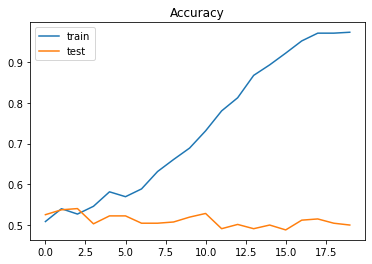

In [13]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();